In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/tie/Tie/graph/navigation/env_hao')

import numpy as np
import networkx as nx
from networkx import to_numpy_matrix
#from itertools import count
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import dgl
import dgl.function as fn

# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# quick start 

Use the dgl library to implement Karate graph task

NetworkXError: random_state_index is incorrect

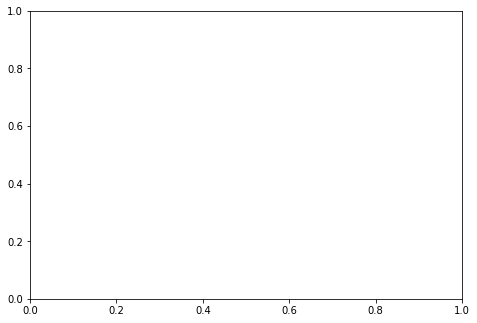

In [8]:
zkc = nx.karate_club_graph()
attr = {n: {"label": int(zkc.nodes[n]['club'] == 'Officer')} for n in zkc.nodes()}
nx.set_node_attributes(zkc, attr)
labels = [zkc.nodes[i]['label'] for i in range(34)]
g = dgl.DGLGraph(zkc)
nx.draw(g.to_networkx())
plt.show()

In [9]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(34, 2)
        self.layer2 = GCNLayer(2, 1)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return F.sigmoid(x)
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=34, out_features=2, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
)


In [11]:
I = torch.eye(zkc.number_of_nodes())
loss = torch.nn.BCELoss()
net(g, I).view(-1)

C:\anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.2751, 0.3351, 0.2892, 0.3522, 0.4067, 0.3913, 0.4016, 0.3950, 0.3921,
        0.4775, 0.4172, 0.4427, 0.4309, 0.3816, 0.4657, 0.4657, 0.4662, 0.4136,
        0.4657, 0.4001, 0.4657, 0.4136, 0.4657, 0.4281, 0.4580, 0.4699, 0.4726,
        0.4637, 0.4624, 0.4532, 0.4210, 0.3873, 0.3741, 0.3040],
       grad_fn=<ViewBackward>)

In [12]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-4)
labels = torch.FloatTensor(labels)
def train():
    net.train()
    optimizer.zero_grad()
    Loss = torch.nn.BCELoss()
    loss = Loss(net(g, I).view(-1), labels.view(-1).float())
    loss.backward()
    optimizer.step()
    return loss, net(g, I).view(-1)

Out = []
for epoch in range(1, 1601):
    loss, out = train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch%80 == 0:
        print (loss)
        Out.append(out)
#         print ('test loss', test())

tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0200, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0099, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0060, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0042, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0031, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0024, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0020, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0017, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0015, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0013, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0012, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0011, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0010, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0010, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0009, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0009, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0008, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0008, grad_fn=<BinaryCrossEntropyBack

NetworkXError: random_state_index is incorrect

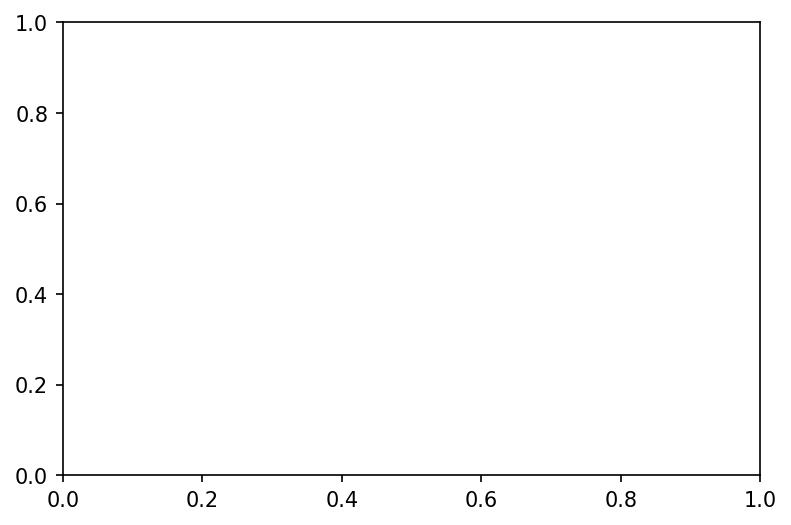

In [13]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    colors = []
    pos = nx.spring_layout(zkc, iterations=500)
    for v in range(34):
        color = Out[i][v].data.numpy()
#         cls = pos[v].argmax()
        colors.append(color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(g.to_networkx(), pos, node_color=np.array(colors),
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.figure()
draw(10)

In [ ]:
# ani = animation.FuncAnimation(fig, draw, frames=len(Out), interval=10)

In [ ]:
# visualization 
output = net(g, I).view(-1)
Att = np.array([(a.data.numpy(), m.data.numpy()) for a, m in zip(output, labels)])
pos = nx.spring_layout(zkc, iterations=500)
nx.draw(zkc, pos, node_color = Att[:, 0], with_labels = True)
plt.figure()
nx.draw(zkc, pos, node_color = Att[:, 1], with_labels = True)

In [41]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    train_mask = th.BoolTensor(data.train_mask)
    test_mask = th.BoolTensor(data.test_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, train_mask, test_mask